# Imports / Config

In [2]:
from datetime import datetime
import os
import sys

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

%matplotlib inline
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [263]:
def subset(df, colnames, values):
    """
    Subsets a df to only those documents where colnames == values.

    Keyword arguments:
    df - dataframe to subset (pandas DataFrame)
    colnames - names of df columns whose values to compare (list of strings)
    values - values to compare with those in df columns (list)

    Returns:
    pandas DataFramd - subset of df
    """
    filt = np.ones(len(df), dtype=bool)
    for colname, value in zip(colnames, values):
        filt = (filt & (df[colname] == value))

    subset = df[filt].copy().reset_index()
    subset.drop(labels=['index'], axis='columns', inplace=True)

    return subset

# Corpus

In [3]:
from corpus import Corpus

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
%%time
recent_content_corpus = Corpus(days_of_recent_content=7, verbose=True)

CPU times: user 2min 22s, sys: 5.73 s, total: 2min 28s
Wall time: 8min 2s


In [5]:
%%time
recent_content_corpus.vectorize()

CPU times: user 3min 25s, sys: 8.39 s, total: 3min 33s
Wall time: 3min 35s


In [6]:
%%time
recent_content_corpus.classify()

accuracy:   0.887

classification report:
                                precision    recall  f1-score   support

 Entertainment, Culture & Arts       0.85      0.92      0.89       699
            Finance & Business       0.79      0.79      0.79       434
  Politics, Policy & Economics       0.87      0.88      0.88       273
                        Sports       0.97      0.98      0.98      1257
Technology, Science & Medicine       0.69      0.59      0.63       176
      Travel, Lifestyle & Food       0.87      0.72      0.78       257

                   avg / total       0.89      0.89      0.89      3096


confusion matrix:
[[ 645   12   12   12    3   15]
 [  23  344   14    9   37    7]
 [  10   17  241    1    2    2]
 [  20    4    1 1230    0    2]
 [  16   49    4    2  103    2]
 [  43   10    4   11    5  184]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:904: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


accuracy:   0.933

classification report:
                      precision    recall  f1-score   support

          Asia & ANZ       0.99      0.85      0.91       169
              Europe       0.85      0.67      0.75        82
       Latin America       1.00      0.25      0.40         8
           Local - 1       0.92      0.98      0.95      2961
          Local - 10       0.95      0.93      0.94      2060
Middle East & Africa       1.00      0.76      0.87        59
       U.S. & Canada       0.88      0.70      0.78       381

         avg / total       0.93      0.93      0.93      5720


confusion matrix:
[[ 143    4    0   15    5    0    2]
 [   1   55    0   14    7    0    5]
 [   0    3    2    3    0    0    0]
 [   0    0    0 2907   36    0   18]
 [   0    0    0  134 1917    0    9]
 [   0    1    0    9    3   45    1]
 [   1    2    0   64   46    0  268]]
CPU times: user 34.4 s, sys: 2.17 s, total: 36.5 s
Wall time: 25.4 s


# Clustering

In [264]:
recent_content_corpus.df.region_classification_predicted.value_counts()

Local - 1               67209
Local - 10              32937
U.S. & Canada           20412
Asia & ANZ               3339
Europe                   2572
Middle East & Africa      792
Latin America             136
Name: region_classification_predicted, dtype: int64

In [265]:
recent_content_corpus.df.topic_classification_predicted.value_counts()

Entertainment, Culture & Arts     43272
Sports                            27488
Finance & Business                24270
Politics, Policy & Economics      18747
Travel, Lifestyle & Food           8485
Technology, Science & Medicine     5135
Name: topic_classification_predicted, dtype: int64

In [266]:
subset_colnames = ['topic_classification_predicted', 'region_classification_predicted']
subset_values = ['Politics, Policy & Economics', 'U.S. & Canada']
corpus = subset(recent_content_corpus.df, subset_colnames, subset_values)

In [267]:
cluster_training_corpus = get_cluster_training_corpus(int(len(corpus)*0.25))
training_cluster_ids_and_n_texts = {}
cluster_id_counts = cluster_training_corpus['training_cluster_id'].value_counts()
for cluster, ct in zip(cluster_id_counts.index, cluster_id_counts.values):
    training_cluster_ids_and_n_texts[cluster] = ct

In [268]:
text_colname = 'title'

In [269]:
corpus_plus = pd.concat(
    [corpus, cluster_training_corpus],
    ignore_index=True
)
corpus_plus[text_colname+'_lemmatized'] = (
    corpus_plus[text_colname].apply(
        lambda x: lemmatize(x, pos_to_keep=['NOUN', 'PROPN'])
    )
)

In [270]:
corpus_plus['title_embedded'] = pd.Series(list(gen_text_embeddings(
    corpus_plus[text_colname+'_lemmatized'], propn_weight=1.3
    #^found that we get better fit if proper nouns upweighted @ 1.3
)))

In [271]:
def gen_ac_tradeoff(ac_result, obs, training_cluster_ids_and_ns,
                    clusters_to_process_between_plots=100, verbose=False):
    obs_ = obs.copy()
    n_obs = len(obs_)

    cluster_members = {}
    for i in np.arange(0, n_obs):
        cluster_members[i] = [i]
    cluster_labels = np.arange(0, n_obs)

    n_clusters = []
    avg_tc_recalls = []
    avg_tc_precisions = []
    avg_tc_f1_scores = []

    for n, clustering in enumerate(ac_result):
        cluster_id = n + n_obs
        lc = clustering[0]
        rc = clustering[1]

        cluster_members[cluster_id] = cluster_members[lc] + cluster_members[rc]
        del cluster_members[lc]
        del cluster_members[rc]

        for obs_id in cluster_members[cluster_id]:
            cluster_labels[obs_id] = cluster_id
        obs_['cluster'] = cluster_labels

        if cluster_id % clusters_to_process_between_plots == 0:
            cluster_counts = obs_['cluster'].value_counts()

            tc_recalls = []
            tc_precisions = []
            weights = []
            for training_cluster_id, obs_count in training_cluster_ids_and_ns.items():
                filt = (obs_['training_cluster_id'] == training_cluster_id)
                training_cluster_counts = obs_[filt]['cluster'].value_counts()

                top_cluster_recall = training_cluster_counts.values[0] * 1.0 / obs_count
                top_cluster_precision = (
                    training_cluster_counts.values[0] * 1.0 / cluster_counts[training_cluster_counts.index[0]]
                )

                tc_recalls.append(top_cluster_recall)
                tc_precisions.append(top_cluster_precision)
                weights.append(obs_count)

            avg_tc_recall = np.average(tc_recalls, weights=weights)
            avg_tc_precision = np.average(tc_precisions, weights=weights)

            n_clusters.append(len(cluster_members))
            avg_tc_recalls.append(avg_tc_recall)
            avg_tc_precisions.append(avg_tc_precision)
            avg_tc_f1_scores.append(2.0/(1.0/avg_tc_recall + 1.0/avg_tc_precision))

    max_avg_tc_f1_scores = max(avg_tc_f1_scores)
    optimal_n_clusters = n_clusters[avg_tc_f1_scores.index(max_avg_tc_f1_scores)]

    if verbose:
        plt.figure(figsize=(12, 8))
        plt.plot(n_clusters, avg_tc_recalls, label='Avg Story TC Recall')
        plt.plot(n_clusters, avg_tc_precisions, label='Avg Story TC Precision')
        plt.plot(n_clusters, avg_tc_f1_scores, label='Avg Story TC F1 Scores')
        plt.legend(loc='best')
        plt.show()
        plt.close()

        print('Max F1 Score: %0.4f' % max_avg_tc_f1_scores)
        print('Optimal N Clusters: %s' % optimal_n_clusters)

    return max_avg_tc_f1_scores, optimal_n_clusters
    
    
def gen_cluster_labels(ac_result, n_clusters):
    n_obs = len(ac_result) + 1

    cluster_members = {}
    for i in np.arange(0, n_obs):
        cluster_members[i] = [i]
    for n, clustering in enumerate(ac_result):
        cluster_id = n + n_obs
        lc = clustering[0]
        rc = clustering[1]

        cluster_members[cluster_id] = cluster_members[lc] + cluster_members[rc]
        del cluster_members[lc]
        del cluster_members[rc]

        if len(cluster_members) == n_clusters:
            break

    cluster_labels = np.arange(0, n_obs)
    for cluster_id, obs_ids in cluster_members.items():
        for obs_id in obs_ids:
            cluster_labels[obs_id] = cluster_id

    return cluster_labels


def summarize_ac(ac_result, n_clusters, docs, query='trump'):
    docs_ = docs.copy()
    n_docs = len(docs_)
    docs_['cluster'] = gen_cluster_labels(ac_result, n_clusters)

    cluster_counts = docs_['cluster'].value_counts()
    largest_cluster = cluster_counts.index[0]
    
    print('***** Cluster counts: *****')
    print(cluster_counts)
    
    print('\n' * 2)
    print('***** Small clusters info: *****')
    small_cluster_records = 0
    for i in np.arange(1, 6):
        records = (sum(docs_['cluster'].value_counts() == i)*i)
        print('Cluster Size %d: %d records' % (i, records))
        small_cluster_records += records
    pct_small_cluster_records = small_cluster_records/n_docs
    print('Pct Records in Small Clusters: %0.3f' % pct_small_cluster_records)
    
    print('\n' * 2)
    print('***** Largest cluster headlines: *****')
    for item in docs_[docs_['cluster'] == largest_cluster]['title']:
        print(item)
    
    filt = docs_['title'].apply(lambda x: query in x.lower())
    cluster_counts = docs_[filt]['cluster'].value_counts()
    print('\n' * 2)
    print('***** %s cluster counts: *****' % query)
    print(cluster_counts)
    
    print('\n' * 2)
    print('***** Largest %s cluster headlines: *****' % query)
    for item in docs_[docs_['cluster'] == cluster_counts.index[0]]['title']:
        print(item)
        
    print('\n' * 2)
    print('***** 2nd Largest %s cluster headlines: *****' % query)
    for item in docs_[docs_['cluster'] == cluster_counts.index[1]]['title']:
        print(item)
        
    print('\n' * 2)
    print('***** 3rd Largest %s cluster headlines: *****' % query)
    for item in docs_[docs_['cluster'] == cluster_counts.index[2]]['title']:
        print(item)

In [272]:
%%time
ac_result = agglomerative_cluster(
    np.asarray(list(corpus_plus[text_colname+'_embedded'])),
    method='average', 
    metric='euclidean', 
    optimal_ordering=False
)

CPU times: user 7.15 s, sys: 246 ms, total: 7.4 s
Wall time: 7.45 s


In [273]:
dist_increases = [ac_result[i+1, 2]-ac_result[i, 2] for i in np.arange(len(ac_result)-1)]

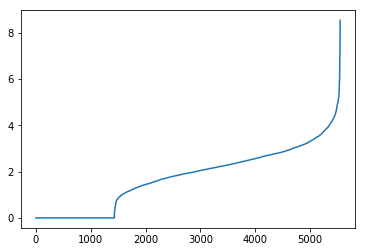

In [274]:
plt.plot(np.arange(len(ac_result)),ac_result[:, 2])
plt.show()

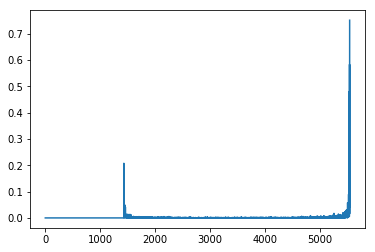

In [275]:
plt.plot(np.arange(len(dist_increases)), dist_increases)
plt.show()

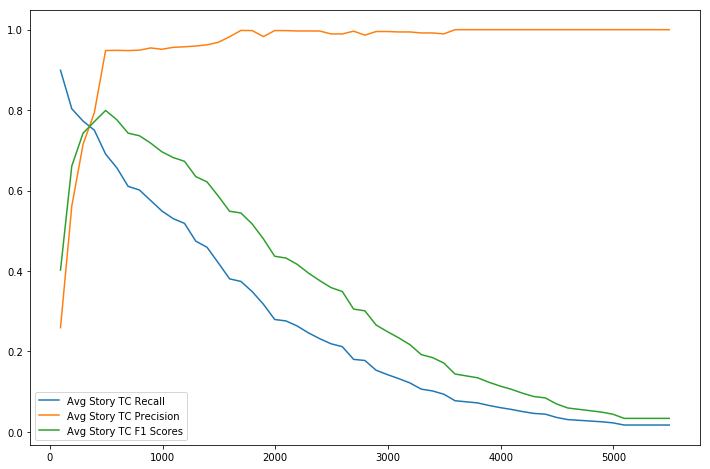

Max F1 Score: 0.7992
Optimal N Clusters: 495
CPU times: user 2.56 s, sys: 207 ms, total: 2.76 s
Wall time: 3 s


In [276]:
%%time
max_avg_story_tc_f1_scores, optimal_n_clusters = (
    gen_ac_tradeoff(ac_result, corpus_plus, training_cluster_ids_and_n_texts, verbose=True)
)

In [277]:
%%time
summarize_ac(ac_result, optimal_n_clusters, corpus_plus, query='kavanaugh')

***** Cluster counts: *****
10563    1544
10556     437
10588     339
10551     147
10558     137
10538     110
10571      93
10597      90
10567      87
10436      83
10591      82
10555      76
10578      73
10577      70
10596      60
10521      56
10448      54
10418      48
10560      45
10503      44
10493      43
10600      37
10559      36
10501      34
10321      29
10460      29
10569      28
10592      26
10585      26
10587      25
         ... 
1006        1
3003        1
4531        1
653         1
2696        1
2152        1
557         1
2552        1
4587        1
4575        1
2524        1
4567        1
4559        1
2743        1
4555        1
425         1
5028        1
417         1
381         1
4840        1
4856        1
341         1
2361        1
4912        1
309         1
2879        1
297         1
4972        1
4992        1
1605        1
Name: cluster, Length: 495, dtype: int64



***** Small clusters info: *****
Cluster Size 1: 223 records
Cluster Size 

Senate committee votes to proceed with Kavanaugh confirmation Video
Democrats seize on circumstantial July 1 theory for Kavanaugh and Ford
Senator's dramatic demand spurs panel to seek FBI Kavanaugh probe
Kavanaugh testimony 'an incredible moment' in US history, says Trump – video
Kavanaugh Friend Mark Judge Says He'll Cooperate With FBI If Investigation Opens
Trump will order FBI probe into Kavanaugh: CNN
Trump approves FBI investigation into Kavanaugh
Donald Trump Orders FBI Investigation of Judge Kavanaugh
Trump orders FBI to reopen background investigation into Kavanaugh
Trump orders FBI to update Kavanaugh file in less than a week
Trump will order FBI probe into Kavanaugh: CNN
Trump orders FBI to update Kavanaugh file in less than a week
Trump will order FBI probe into Kavanaugh: CNN
Kavanaugh's Friend Mark Judge Says He Will Cooperate With FBI Probe
Brett Kavanaugh: Donald Trump orders new FBI probe into Supreme Court pick following Senate request
Brett Kavanaugh: Donald Trump or

'Trying to destroy a great man:' Trump doubles down on defense of Kavanaugh
Kavanaugh accuser Julie Swetnick alleges he was 'very aggressive,' but her account raises new questions
GOP Sen Kennedy: FBI Will Just Redo What They Already Did on Kavanaugh – If You Think This Is About Truth, ‘Put Down the Bong’
GOP Sen Kennedy: FBI Will Just Redo What They Already Did on Kavanaugh – If You Think This Is About Truth, ‘Put Down the Bong’
Harvard Says Kavanaugh Won’t Be Teaching His 2019 Supreme Court Class
A New Front in the Kavanaugh Wars: Temperament and Honesty
Susan Ellingstad’s Keith Ellison probe finds abuse claims ‘unsubstantiated,’ is met with skepticism
FBI digs into Supreme Court nominee Kavanaugh's past
FBI digs into Supreme Court nominee Kavanaugh's past
Flake says FBI believed Kavanaugh investigation would be done in a week
FBI digs into U.S. Supreme Court nominee Kavanaugh's past
FBI grills second woman accusing judge Kavanaugh of sexual assault
FBI digs into U.S. Supreme Court n

Trump says he'll accept delay in Senate confirmation vote for Kavanaugh
Trump says he found Kavanaugh accuser's testimony 'very compelling,' but says no consideration of re
‘Somebody’s gotta explain this to Trump’ — Lindsey Graham’s lament after Senate maneuver
Who Is Voting for Brett Kavanaugh? Here's How Every Senator Has Indicated They Will Vote on Supreme Court Nominee
Who Is Voting for Brett Kavanaugh? Here's How Every Senator Has Indicated They Will Vote on Supreme Court Nominee
Senate Democrat Manchin joins Flake's call for FBI probe of Kavanaugh
Republican Senator Murkowski backs idea of delay in vote on Kavanaugh
Republican Senator Murkowski backs idea of delay in vote on Kavanaugh
The Division that the Brett Kavanaugh Vote Won't Change
The Division that the Brett Kavanaugh Vote Won't Change
Kavanaugh: Confusion reigns at the end of Senate hearing
Kavanaugh friend Mark Judge: 'I will cooperate' with FBI probe of sex assault claims
Key senator demands FBI probe as panel backs T


***** 3rd Largest kavanaugh cluster headlines: *****
Republicans, You're in Charge: Confirm Kavanaugh and Move On
The Note: Kavanaugh’s fate rests on vanishing middle
The Burden Lies With Judge Kavanaugh
Trump says he would have pushed Kavanaugh through
Read Kavanaugh's prepared testimony
The Burden Lies With Judge Kavanaugh
The Burden Lies With Judge Kavanaugh
Trump: 'I could be persuaded' to change mind on Kavanaugh after hearing
Trump performs his best material, but fails on Kavanaugh
Kavanaugh confirmation: What to watch
Kavanaugh confirmation: What to watch
What Kavanaugh should have done
The Most Noteworthy Moments from the Kavanaugh Hearing
Kavanaugh comes out swinging: Charges against me are a ‘national disgrace’
Kavanaugh: I've never sexually assaulted anyone
Frustrated Trump turns optimistic on Kavanaugh
Trump: Kavanaugh showed 'exactly why I nominated him'
Frustrated Trump turns optimistic on Kavanaugh
With his fiery testimony, Kavanaugh appears more Trump-like than ever
Ka

In [278]:
corpus_plus['story_cluster_id'] = gen_cluster_labels(ac_result, optimal_n_clusters)

In [279]:
corpus = corpus_plus[~corpus_plus['training_cluster_id'].notnull()]

In [280]:
cluster_id_counts = corpus['story_cluster_id'].value_counts()
top_cluster_id = cluster_id_counts.index[0]

In [281]:
df = corpus[corpus['story_cluster_id'] == top_cluster_id].reset_index()

In [362]:
N = len(df)
topic_classifiation = df['topic_classification_predicted'][0]
region_classification = ('U.S. & Canada' 
                         if df['region_classification_predicted'][0] == 'U.S. & Canada'
                         else 'World')
story_cluster_id = sha1(np.asarray(df['url'])).hexdigest()

In [283]:
ac_result = agglomerative_cluster(
    np.asarray(list(df['title_embedded'])),
    method='average',
    metric='euclidean',
    optimal_ordering=False
)

In [315]:
from scipy.ndimage import gaussian_filter

In [356]:
dists = gaussian_filter(ac_result[:, 2], 10)

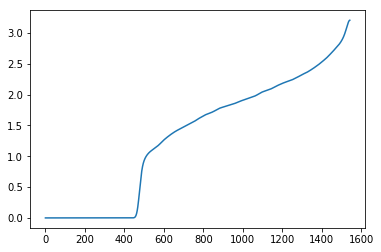

In [357]:
plt.plot(np.arange(len(dists)), dists)
plt.show()

In [358]:
dist_increases = [dists[i+1]-dists[i] for i in np.arange(len(dists)-1)]

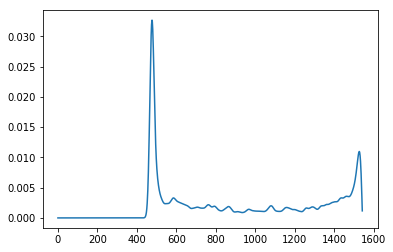

In [359]:
plt.plot(np.arange(len(dist_increases)), dist_increases)
plt.show()

In [360]:
dist_increase_changes = [dist_increases[i+1]-dist_increases[i] for i in np.arange(len(ac_result)-2)]

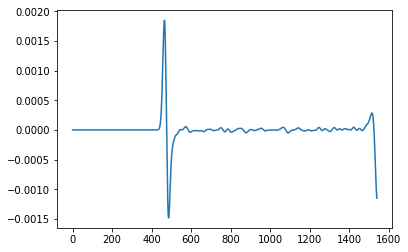

In [361]:
plt.plot(np.arange(len(dist_increase_changes)), dist_increase_changes)
plt.show()

In [287]:
summarize_ac(ac_result, N//10, df, query='kavanaugh')

***** Cluster counts: *****
2914    216
2916    122
2864     91
2929     79
2900     50
2925     38
2898     34
2912     32
2927     28
2829     27
2847     26
2889     25
2921     24
2888     23
2933     23
2782     20
2908     19
2919     19
2845     19
2917     18
2857     18
2910     18
2834     17
2815     17
2896     16
2906     15
2878     15
2928     15
2840     14
2882     13
       ... 
229       1
213       1
196       1
87        1
79        1
32        1
11        1
1059      1
536       1
1498      1
1253      1
846       1
1496      1
1482      1
1444      1
1420      1
1417      1
1392      1
1366      1
1241      1
550       1
1149      1
1141      1
670       1
1118      1
1062      1
574       1
813       1
1061      1
821       1
Name: cluster, Length: 154, dtype: int64



***** Small clusters info: *****
Cluster Size 1: 41 records
Cluster Size 2: 32 records
Cluster Size 3: 60 records
Cluster Size 4: 44 records
Cluster Size 5: 35 records
Pct Records in Small Cluster

In [288]:
df['perspective_cluster_id'] = gen_cluster_labels(ac_result, N//10)

In [289]:
cluster_id_counts = df['perspective_cluster_id'].value_counts()

In [224]:
for cluster_id, ct in zip(cluster_id_counts.index, cluster_id_counts.values):
    if ct >= 10:
        subset = df[df['perspective_cluster_id'] == cluster_id]
        perspective_cluster_id = sha1(np.asarray(subset['url'])).hexdigest()
        member_urls = subset['url'].str.cat(sep=', ')
        cluster_data = {
            'create_timestamp': str(datetime.utcnow()),
            'topic_classifiation': topic_classifiation,
            'region_classification': region_classification,
            'story_cluster_id': story_cluster_id,
            'perspective_cluster_id': perspective_cluster_id,
            'size': ct,
            'member_urls': member_urls
        }
#         content_clusters.insert_one(cluster_data)